# Lesson 10 


First 15 minutes of the lecture are a showcase of student work and then a review / recap of how stable diffusion works. 


### Recent Papers 
Then he talks about two paper that came out recently (relative to the lecture)
[Progressive Distillation for Fast Sampling of Diffusion Models](https://arxiv.org/abs/2202.00512) [paper walkthrough](https://www.youtube.com/watch?v=ZXuK6IRJlnk) .
This takes use from 60 steps of denoising to just a few using 'distillation' of the model (which is a form of transfer learning).

The teacher model is our fully trained stable diffusion model.  Then a student model (a unnet) is trained to skip over steps prgressively.  

Another paper from same group shows how to use distillation for guided diffusion models:
[On Distillation of Guided Diffusion Models](https://arxiv.org/abs/2210.03142)



 [Imagic: Text-Based Real Image Editing with Diffusion Models](https://arxiv.org/abs/2210.09276)

 The idea here is that you give the model an image and a text prompt.  It uses the text prompt to modify the image. For example, a picture of a dog and the prompt "A dog sitting" will create a picture of the same dog, sitting.

 The method to make this work is:

 1- Train the embedding of the text prompt to be close to the the image.   This finds an embedding that is close the image but also close to the text prompt.

 2 - Fine tune the whole model, using the new embedding, to the image. 
 
 3 - Use the model to generate the new image, interpolating between the original text embedding and the new one.. 


And, there is also this paper [Intruct Pix to Pix](https://arxiv.org/abs/2211.09800) that does the same kind of thing, except instead of providing a label of the final image, you provide *instructions*.   (e.g. "Add fireworks to the sky"). This is a specially trained model, using a dataset of images and instructions that were created from stable diffusion and GPT models.  

## Stable Diffusion walkthrough

(Around 33 minutes in)
The next part of the video continues to walk throuhg `stable_diffusion.ipynb` on [github](https://github.com/fastai/diffusion-nbs)

This digs into the pipeline more, seperately creating the text embeddings and using the models unet to generate the diffusion steps.  I am not goint to repeat it here.

Some notes:

- The Unet needs to know the 'timestep', that is the amount of noise that was added to the image. As Jeremy said last week this was soemthing he brushed over, but the model gets this information during training, so we have to pass it in during inference as well, following the same schedule.  

- Also as discussed last week, the model does inference on both guided and unguided diffusion. [Classifier free guidance](https://arxiv.org/abs/2207.12598) These are interpolated (in the latent space) by the `guidance scale` parameter.   The videos so far have not gone into the details of how this works, but it is in the paper (and there are other videos that do go into it).  Perhaps it is in the extra video [Stable Diffusion Deep Dive](https://www.youtube.com/watch?v=844LY0vYQhc).  The basic idea is that simply denoising with text guidance is not enough,and so the trick that is used is to denoise with guidance and without guidance.  That take the difference and multiply it by some number >1 (`guidance scale`) to exaggerate the difference.   This is added to the unguided result 'extrapolate' the guidance.  This is done at each timestep :

```python
   for i, t in enumerate(tqdm(scheduler.timesteps)):
    input = torch.cat([latents] * 2)
    input = scheduler.scale_model_input(input, t)

    # predict the noise residual
    with torch.no_grad(): pred = unet(input, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    pred_uncond, pred_text = pred.chunk(2)
    pred = pred_uncond + guidance_scale * (pred_text - pred_uncond)

    # compute the "previous" noisy sample
    latents = scheduler.step(pred, t, latents).prev_sample
```


## Back to to foundations. . 

(at 53:30 https://www.youtube.com/watch?v=6StU6UtZEbU ) 

Notebooks for this part are at [Course22p2](https://github.com/fastai/course22p2)

The rules are we are allowed to use:

- Python
- matplotlib
- python standard library
- Jupyter notebooks and nbdev 

However, we *are* allowed to use other libraries once we have implemented them (not necessarily completly).  
For stuff not in a library, we will put them in 'minai' library.

Another trick is we will create smaller versions of the models, and then once we got them working we will then use the available pre-trained models. 

In this notebook i will follow along but probably skip over some details and excursions.

### Numpy Arrays and Tensors



In [1]:
from pathlib import Path
import pickle, gzip, math, os, time, shutil, matplotlib as mpl, matplotlib.pyplot as plt

Let's get some data to play with

In [2]:
# Michael Nielsen's mnist data is getting a lot of use!
# it is a gziped pickle file 
MNIST_URL='https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true'
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path_gz = path_data/'mnist.pkl.gz'

In [3]:
from urllib.request import urlretrieve
if not path_gz.exists():
    print('Downloading MNIST data...')
    urlretrieve(MNIST_URL, path_gz)

In [4]:
!ls -lh data

total 17M
-rw-r--r-- 1 ron ron  17M Sep 10 11:07 mnist.pkl.gz
drwxr-xr-x 2 ron ron 4.0K Jun 21 10:00 titanic


In [39]:
with gzip.open(path_gz, 'rb') as f:
     ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

# the third tuple is the test set, which we dont need for now.

Note that i copied the above into minai/mnist_load.py for future use

In [13]:
# we aren't allowed to use numpy, so we will convert these to lists. (They are numpy currently)
lst1 = list(x_train[0])
len(lst1)
vals = lst1[200:220]
vals

[0.0,
 0.0,
 0.0,
 0.19140625,
 0.9296875,
 0.98828125,
 0.98828125,
 0.98828125,
 0.98828125,
 0.98828125,
 0.98828125,
 0.98828125,
 0.98828125,
 0.98046875,
 0.36328125,
 0.3203125,
 0.3203125,
 0.21875,
 0.15234375,
 0.0]

These are 28x28 images... lets turn them into an image.


In [7]:
def chunks(x, sz):
    for i in range(0, len(x), sz):
      yield x[i:i+sz]  # this is a generator

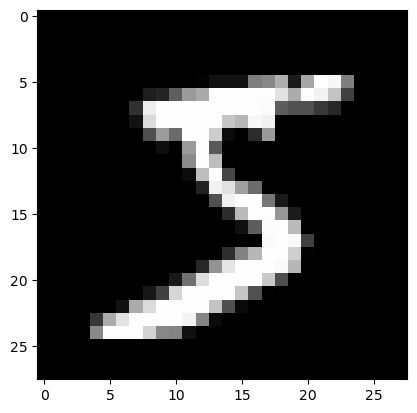

In [8]:
mpl.rcParams['image.cmap'] = 'gray'    
plt.imshow(list(chunks(lst1, 28)))

This is another way of doing it.  

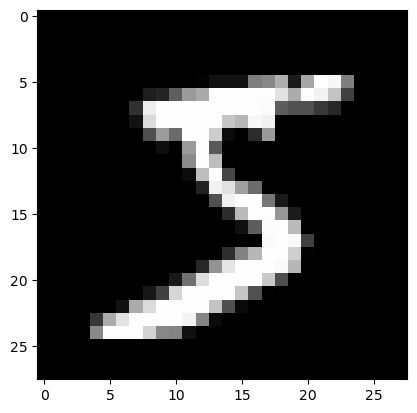

In [25]:
from itertools import islice
it = iter(lst1)
img = list(iter(lambda: list(islice(it, 28)), []))

plt.imshow(img)

### Matrix and tensor

We want to be able to index a matrix like this `m[0,1]` rather then `m[0][1]`. SO lets make a class that does this.

In [36]:
class Matrix:
    def __init__(self, xs): 
        self.xs = xs 
    def __getitem__(self, idxs):
        #print(f"type of idxs: {type(idxs)}")
        return self.xs[idxs[0]][idxs[1]]
 
test = Matrix(img)
test[20,15]

0.98828125

Now that we have implemented this one part, we can use this one part of pytorch.

In [33]:
import torch
from torch import tensor

In [34]:
tens = tensor(img)

In [35]:
tens[20,15]

tensor(0.9883)

Ok we can convet our data into tensors

In [40]:
x_train, y_train, x_valid, y_valid = map(tensor, (x_train, y_train, x_valid, y_valid))
x_train.shape

torch.Size([50000, 784])

In [41]:
# reshape the data to 2d
imgs = x_train.reshape((-1, 28, 28))
imgs.shape

torch.Size([50000, 28, 28])

In [43]:
min(y_train), max(y_train)

(tensor(0), tensor(9))

Note these are scalar (rank 0) tensors, but this is fine they work the same most of the time as ordinary numbers.

#### Tensor programming history

* Digression on [APL](https://tryapl.org/) .  Apparently Ken Iverson is the one that first introduced tensors into programming. He calls them arrays though. (as does numpy).

* Replaces loops with elementwise operations (like numpy, pytorch, etc)

* [Fast ai notes on apl](https://github.com/fastai/apl-study) and [forum](https://forums.fast.ai/c/array-programming/56)



### Random numbers

We are allowed to use python standard library rnd, but it is very instructive to build your own. 

In [44]:
rnd_state = None
def seed(a):
    global rnd_state
    a, x = divmod(a, 30268)
    a, y = divmod(a, 30306)
    a, z = divmod(a, 30322)
    rnd_state = int(x)+1, int(y)+1, int(z)+1


seed(457428938475)
rnd_state

(4976, 20238, 499)

In [45]:

def rand():
    global rnd_state
    x, y, z = rnd_state
    x = (171 * x) % 30269
    y = (172 * y) % 30307
    z = (170 * z) % 30323
    rnd_state = x,y,z
    return (x/30269 + y/30307 + z/30323) % 1.0
     
[rand() for _ in range(5)]

[0.7645251082582081,
 0.7920889799553945,
 0.06912886811267205,
 0.9559050644103264,
 0.840065633394744]

Note issue with forking, the same seed will give the same random numbers.

In [46]:
if os.fork(): print(f'In parent: {rand()}')
else:
    print(f'In child: {rand()}')
    os._exit(os.EX_OK)

In parent: 0.15532781424845843
In child: 0.15532781424845843

/tmp/ipykernel_850/2916155298.py:1: DeprecationWarning: This process (pid=850) is multi-threaded, use of fork() may lead to deadlocks in the child.
  if os.fork(): print(f'In parent: {rand()}')


numpy has a 'spawn' method for dealing with just such situations. Pytorch doesn't seem to.

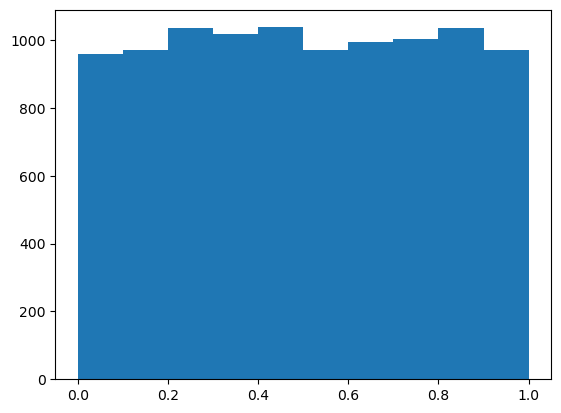

In [47]:

plt.hist([rand() for _ in range(10000)]);

Ok but we will use pytorch random numbers.

In [49]:
torch.randn(3,3)

tensor([[-0.1131, -0.5290, -0.1710],
        [-0.8278,  0.5575, -1.3298],
        [-1.2387, -0.4881, -0.9719]])

In [62]:
tg = torch.Generator()
 

if os.fork(): print(f'In parent: {torch.rand(1, generator=tg)}')
else:
    tg2 = torch.Generator()
    tg2.manual_seed(tg.seed() + 1)
    print(f'In child: {torch.rand(1, generator=tg2)}')
    os._exit(os.EX_OK)

In child: tensor([0.1161])In parent: tensor([0.2673])


/tmp/ipykernel_850/1674585013.py:4: DeprecationWarning: This process (pid=850) is multi-threaded, use of fork() may lead to deadlocks in the child.
  if os.fork(): print(f'In parent: {torch.rand(1, generator=tg)}')


Seems like it is enough to incrment the seed for each thread?

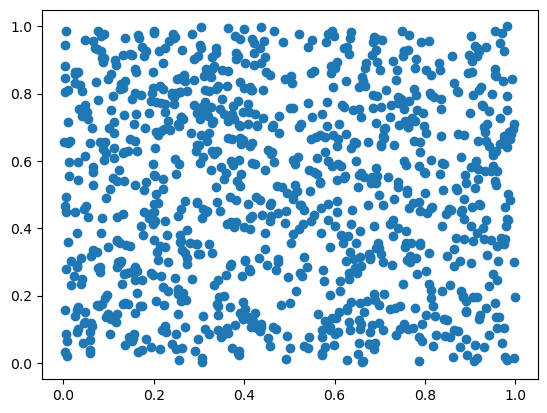

In [67]:
tg = torch.Generator()
tg.manual_seed(42)
tg2 = torch.Generator()
tg2.manual_seed(43)

x = torch.rand(1000, generator=tg)
y = torch.rand(1000, generator=tg2)
plt.scatter(x, y)